<a href="https://colab.research.google.com/github/gulabpatel/TimeSeries/blob/main/26_Lag_Llama_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting

![lag-llama-architecture](https://raw.githubusercontent.com/time-series-foundation-models/lag-llama/main/images/lagllama.webp)

Lag-Llama is the <b>first open-source foundation model for time series forecasting</b>!

Tweet Thread: https://twitter.com/arjunashok37/status/1755261111233114165

HuggingFace: https://huggingface.co/time-series-foundation-models/Lag-Llama

Colab Demo: https://colab.research.google.com/drive/13HHKYL_HflHBKxDWycXgIUAHSeHRR5eo?usp=sharing

GitHub: https://github.com/time-series-foundation-models/lag-llama

Paper: https://time-series-foundation-models.github.io/lag-llama.pdf

💫 This Colab Demo shows you how to use the pretrained Lag-Llama model to get zero-shot predictions on time series.





We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.



In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 71 (delta 25), reused 54 (delta 14), pack-reused 0
Receiving objects: 100% (71/71), 169.42 KiB | 16.94 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
cd lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet # this could take some time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpe1_6phv4
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 169MB/s]
/content/lag-llama/lag-llama.ckpt


We import the required packages and the lag llama estimator object which we can use to make predictions.

In [5]:
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

We download the [Melbourne Pedestrian Counts](https://zenodo.org/records/3898350) dataset used in our [paper](https://time-series-foundation-models.github.io/lag-llama.pdf). This is a dataset that the model has never seen before.

We then set the forecast length of the dataset for inference. Here we use the default prediction length of the dataset (48).

Note how the frequency of the dataset does not matter, since lag-llama can (train and) perform inference with any data of any frequency.

In [6]:
dataset = get_dataset("pedestrian_counts")

backtest_dataset = dataset.test
prediction_length = dataset.metadata.prediction_length
context_length = 32

Download pedestrian_counts_dataset.zip:: 4.38MB [00:02, 1.65MB/s]
creating json files: 100%|██████████| 66/66 [00:00<00:00, 61543.81it/s]


We create a model object with the hyperparameters from the pretrained model, and the prediction length.

In [7]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [8]:
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

We perform inference on this dataset zero-shot!

In [9]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
)

In [10]:
forecasts = list(forecast_it)
tss = list(ts_it)

We obtain some metrics for our reference. The CRPS metric is a commonly used metric in time series forecasting literature. We obtain a CRPS of **0.2531** with this dataset (close to the number reported in Table 1 of the [paper](https://time-series-foundation-models.github.io/lag-llama.pdf)).

In [11]:
evaluator = Evaluator()

In [12]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 66it [00:00, 1660.80it/s]


In [13]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.2526684314204291


We plot the forecasts of our model on this dataset.

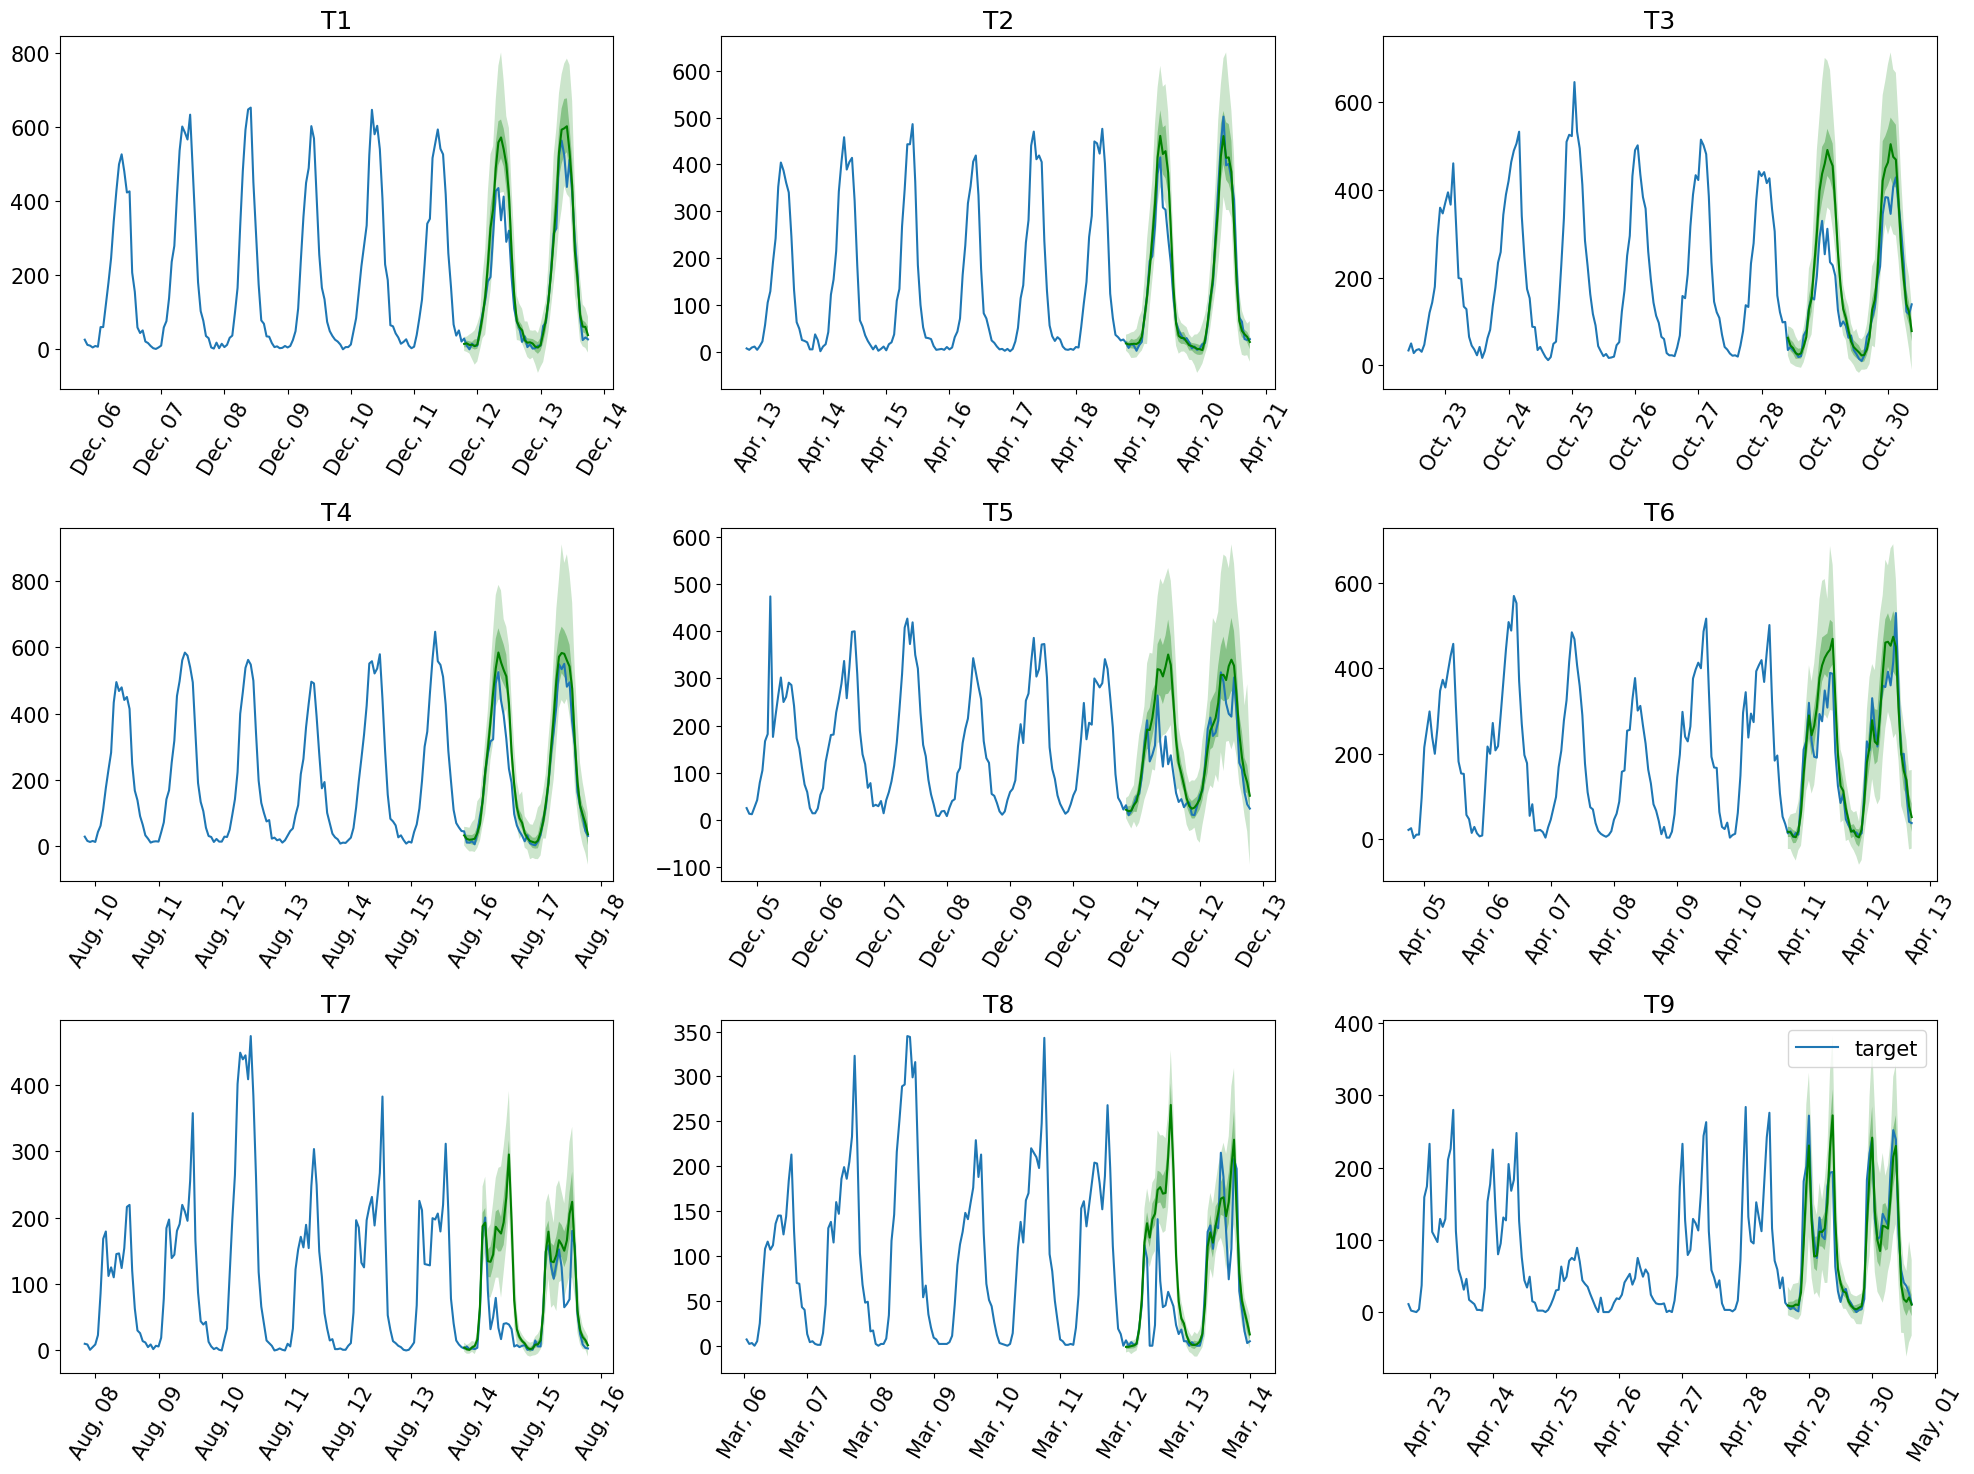

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Coming Soon:

⭐ An <b>online gradio demo</b> where you can upload time series and get zero-shot predictions.

⭐ Features for <b>finetuning</b> the foundation model

⭐ Features for <b>pretraining</b> Lag-Llama on your own large-scale data

⭐ Scripts to <b>reproduce</b> all results in the paper.


____

Stay Tuned!🦙